In this notebook we want to fine-tune the newest yolo, yolov8, for face detection. For this we annotate the 60 face pictures in Roboflow and use this to train the yolo model to detect the class "faces". In the notbook we use YOLOv8 (https://docs.ultralytics.com/) and follows the tutorial https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb

### Installing and importing libraraies

In [1]:
!pip install roboflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00


In [2]:
!pip install ultralytics roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
from IPython.display import display,Image
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
from roboflow import Roboflow
import torch
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Get data

The tool Roboflow allows to get the annotated data via API. The annotations are already in the yolov8 compatible format

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="NTY56w29fWi7uMoyFH9r")
project = rf.workspace("facescv").project("faces_512x512")
dataset = project.version(1).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.196, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to Faces_512x512-1 in yolov8:: 100%|██████████| 132/132 [00:00<00:00, 2574.38it/s]


### Train model

We train the model for the detection task. In the data_changed.yaml file we have specified number of classes (1), class name ("faces") and the location of train, validation and test dataset. The folders are prepared in Roboflow, and can be downloaded by the code above, but due to the fact that we use Google Colab the paths needed to be changed. Due to this we downloaded the data.yaml file and hardcoded the locations in the data_changed.yaml.
The model was trained for 128 epochs. The tool Roboflow resized the pictures to 640 px. In this tool we augmented also the data a bit for better generalization. Each picture was three time changed for rotation between -24° and 24° and up to 5% noise was added to every pixel.


In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data=../content/drive/MyDrive/ComputerVision/Code/data_changed_60_faces.yaml epochs=128 imgsz=640 plots=True

100% 49.7M/49.7M [00:00<00:00, 72.1MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=../content/drive/MyDrive/ComputerVision/Code/data_changed_60_faces.yaml, epochs=128, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=Fals

The model has built-in early stopping, so it stops in 60 epochs if the performance did not improve. In this case it stopped in the epoch 112 and reached the following metrics for bounding box detection:

Precision: 0.77

Recall:0.913

MAP50:0.903

The MAP50 metric is MAP calculated at IOU threshold 0.5

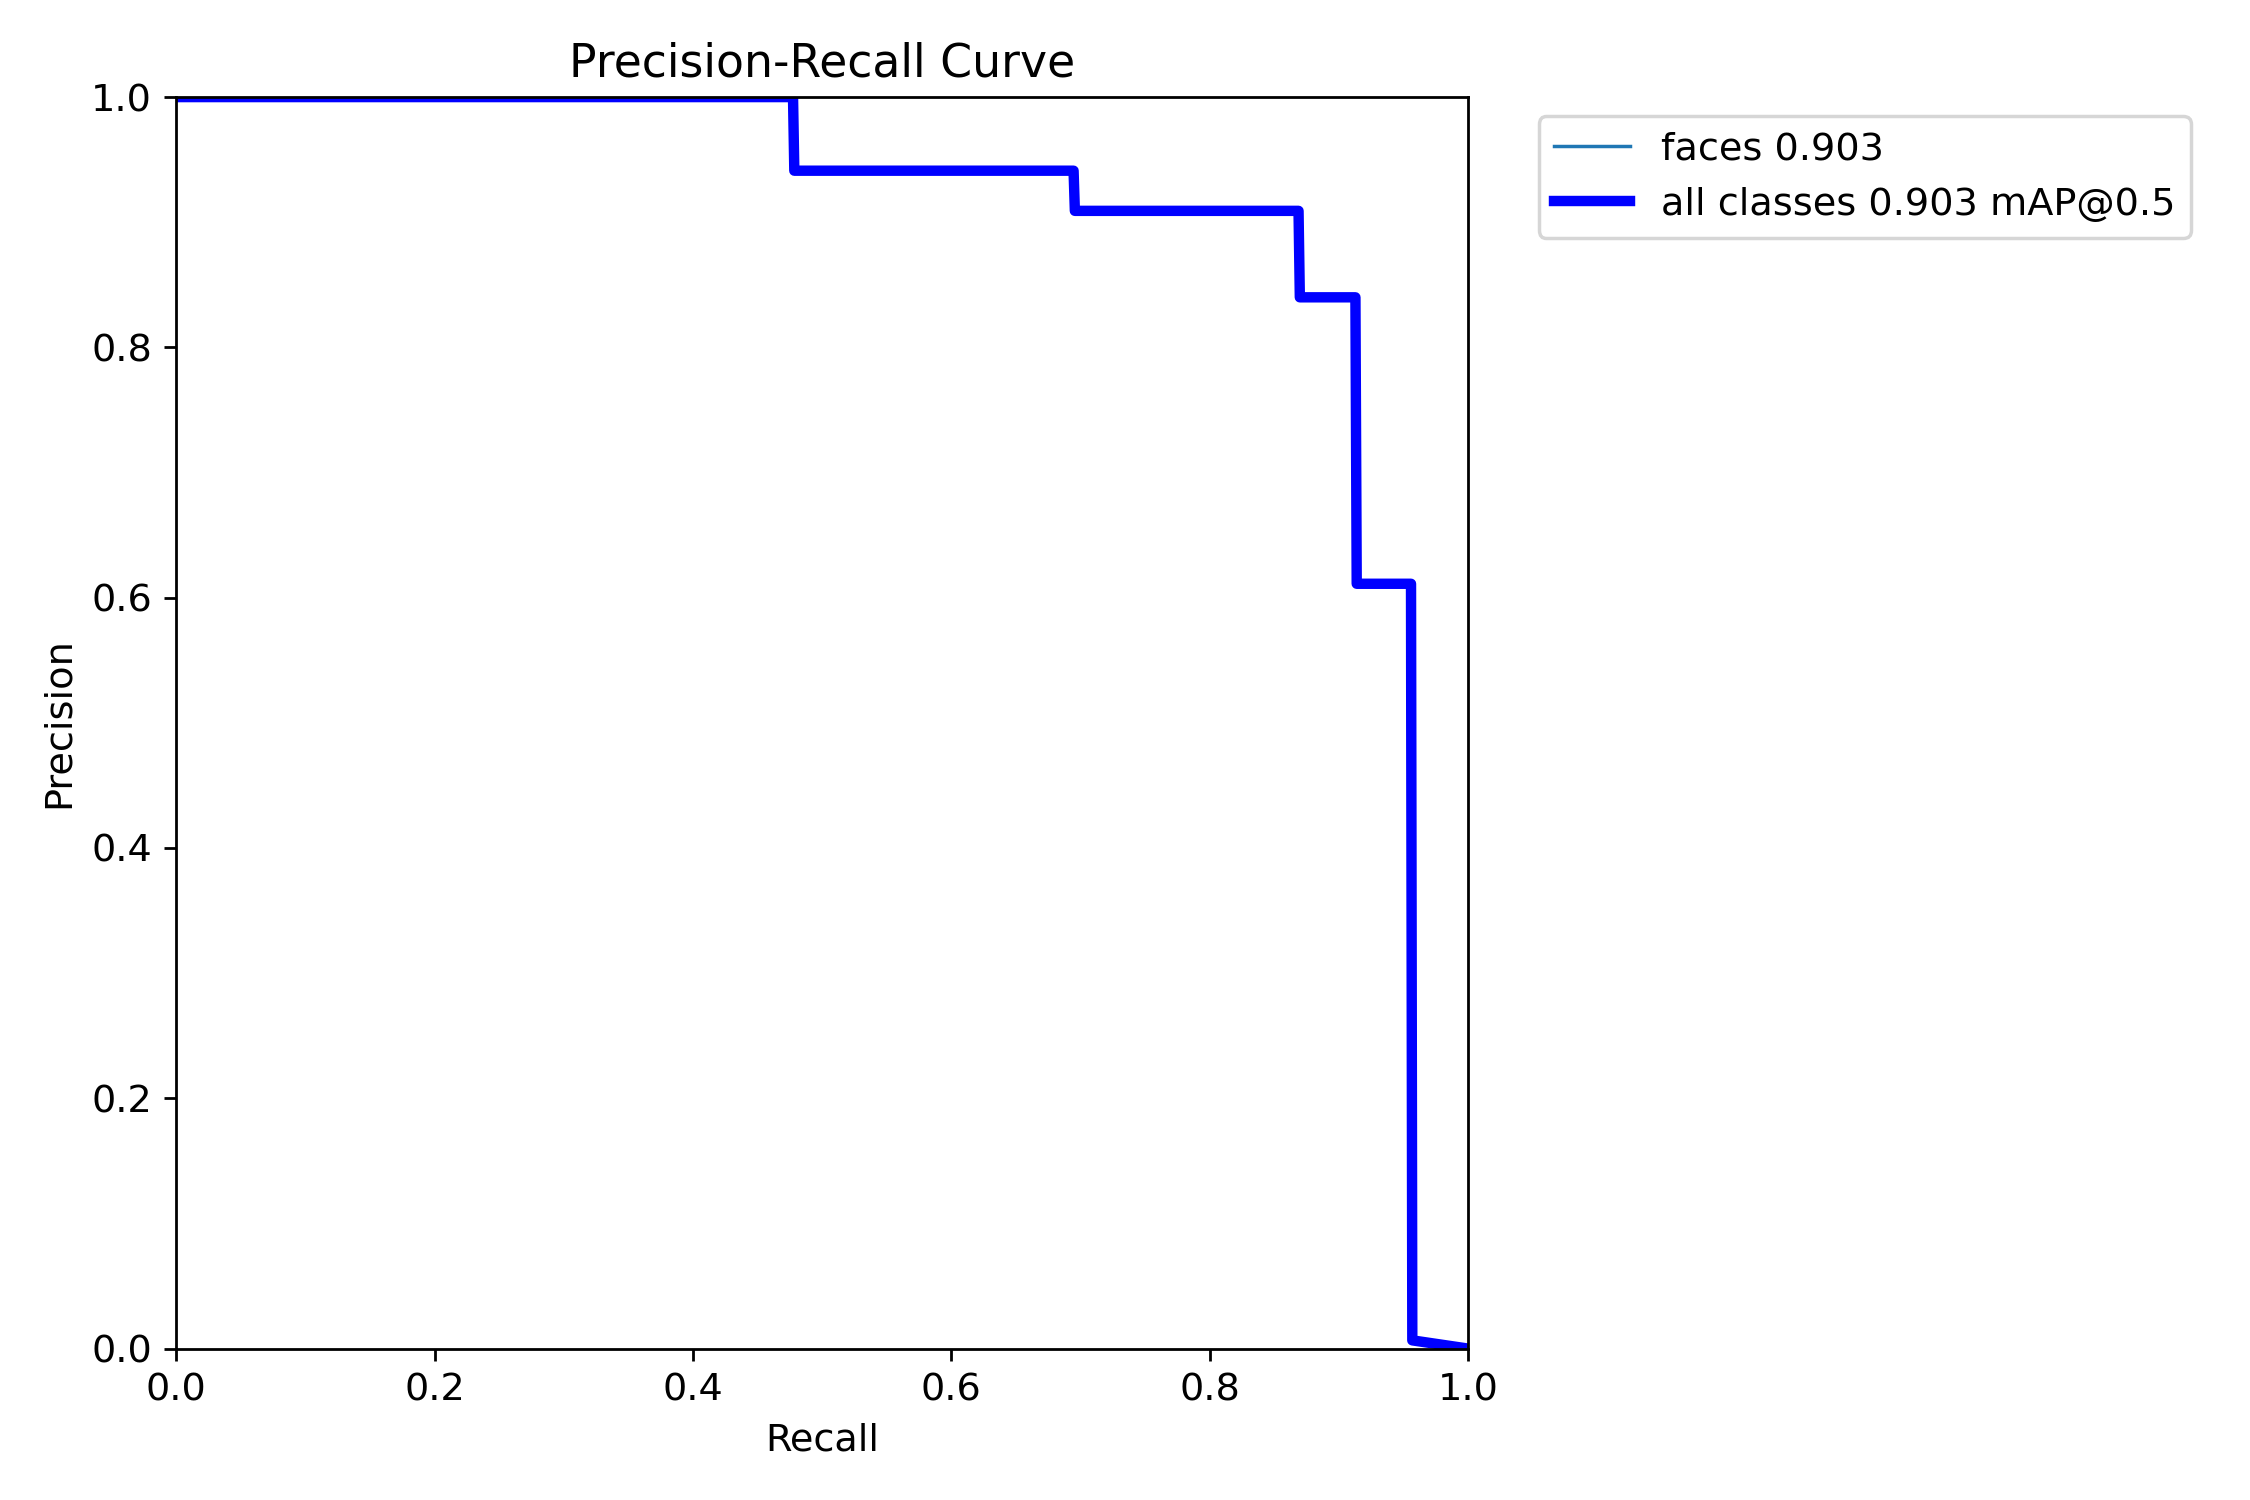

In [ ]:
Image.open("/content/runs/detect/train/PR_curve.png")

In the graph of the Precision-Recall curve we can see that the model achieves a good performance. It is close to point (1,1).

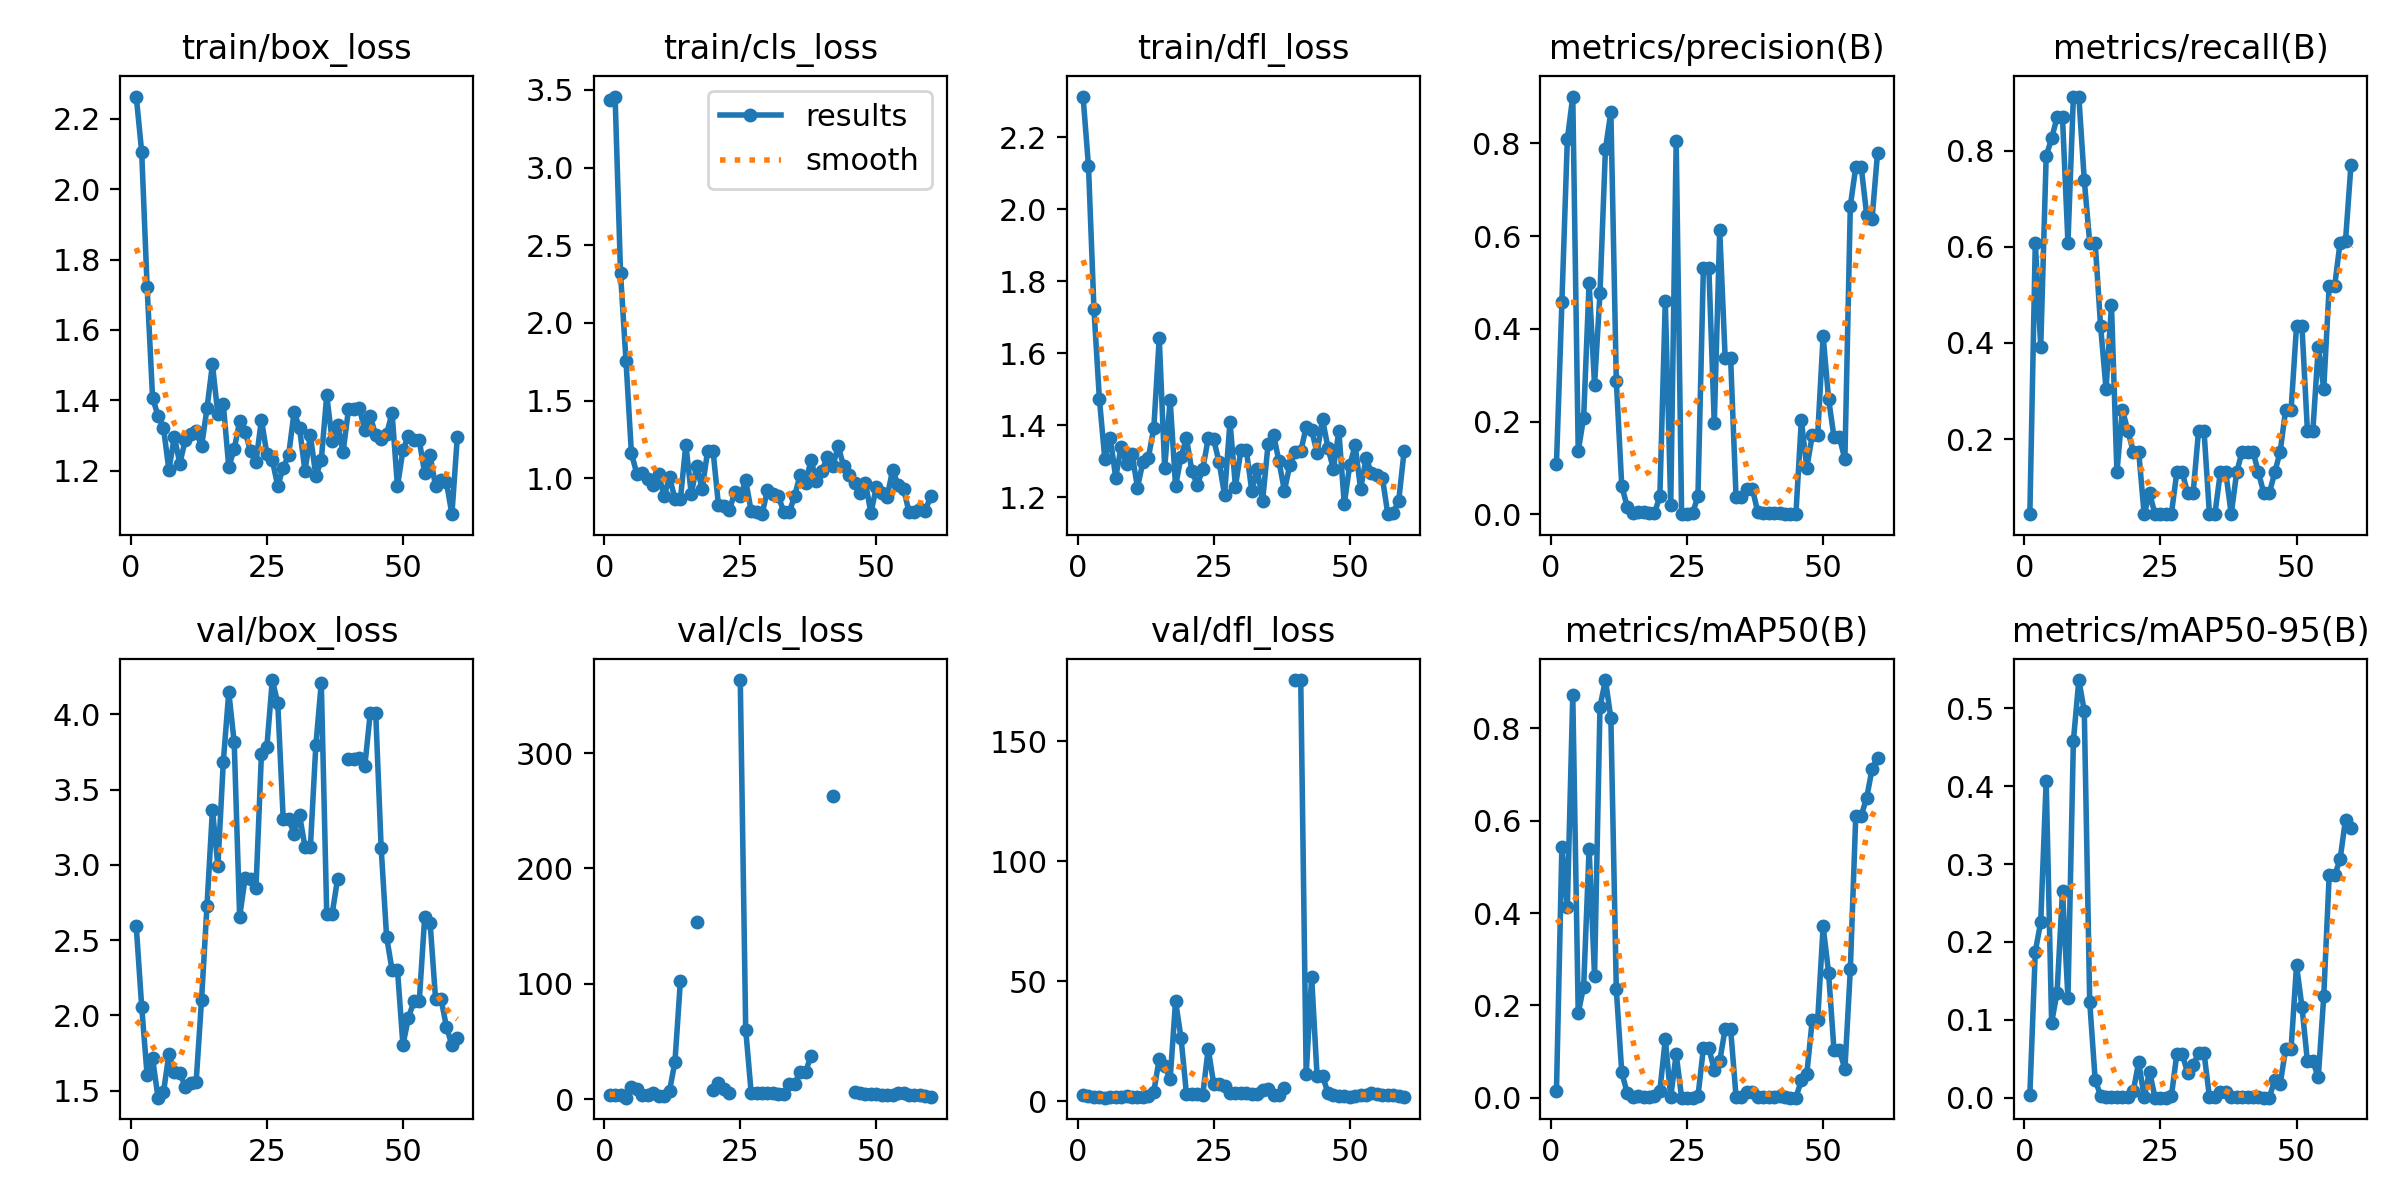

In [ ]:
Image.open("/content/runs/detect/train/results.png")

In the loss plots we can see that it decreases. On the evaluation metrics we can see that the model changes its performance between the epochs - it is not constantly improving.

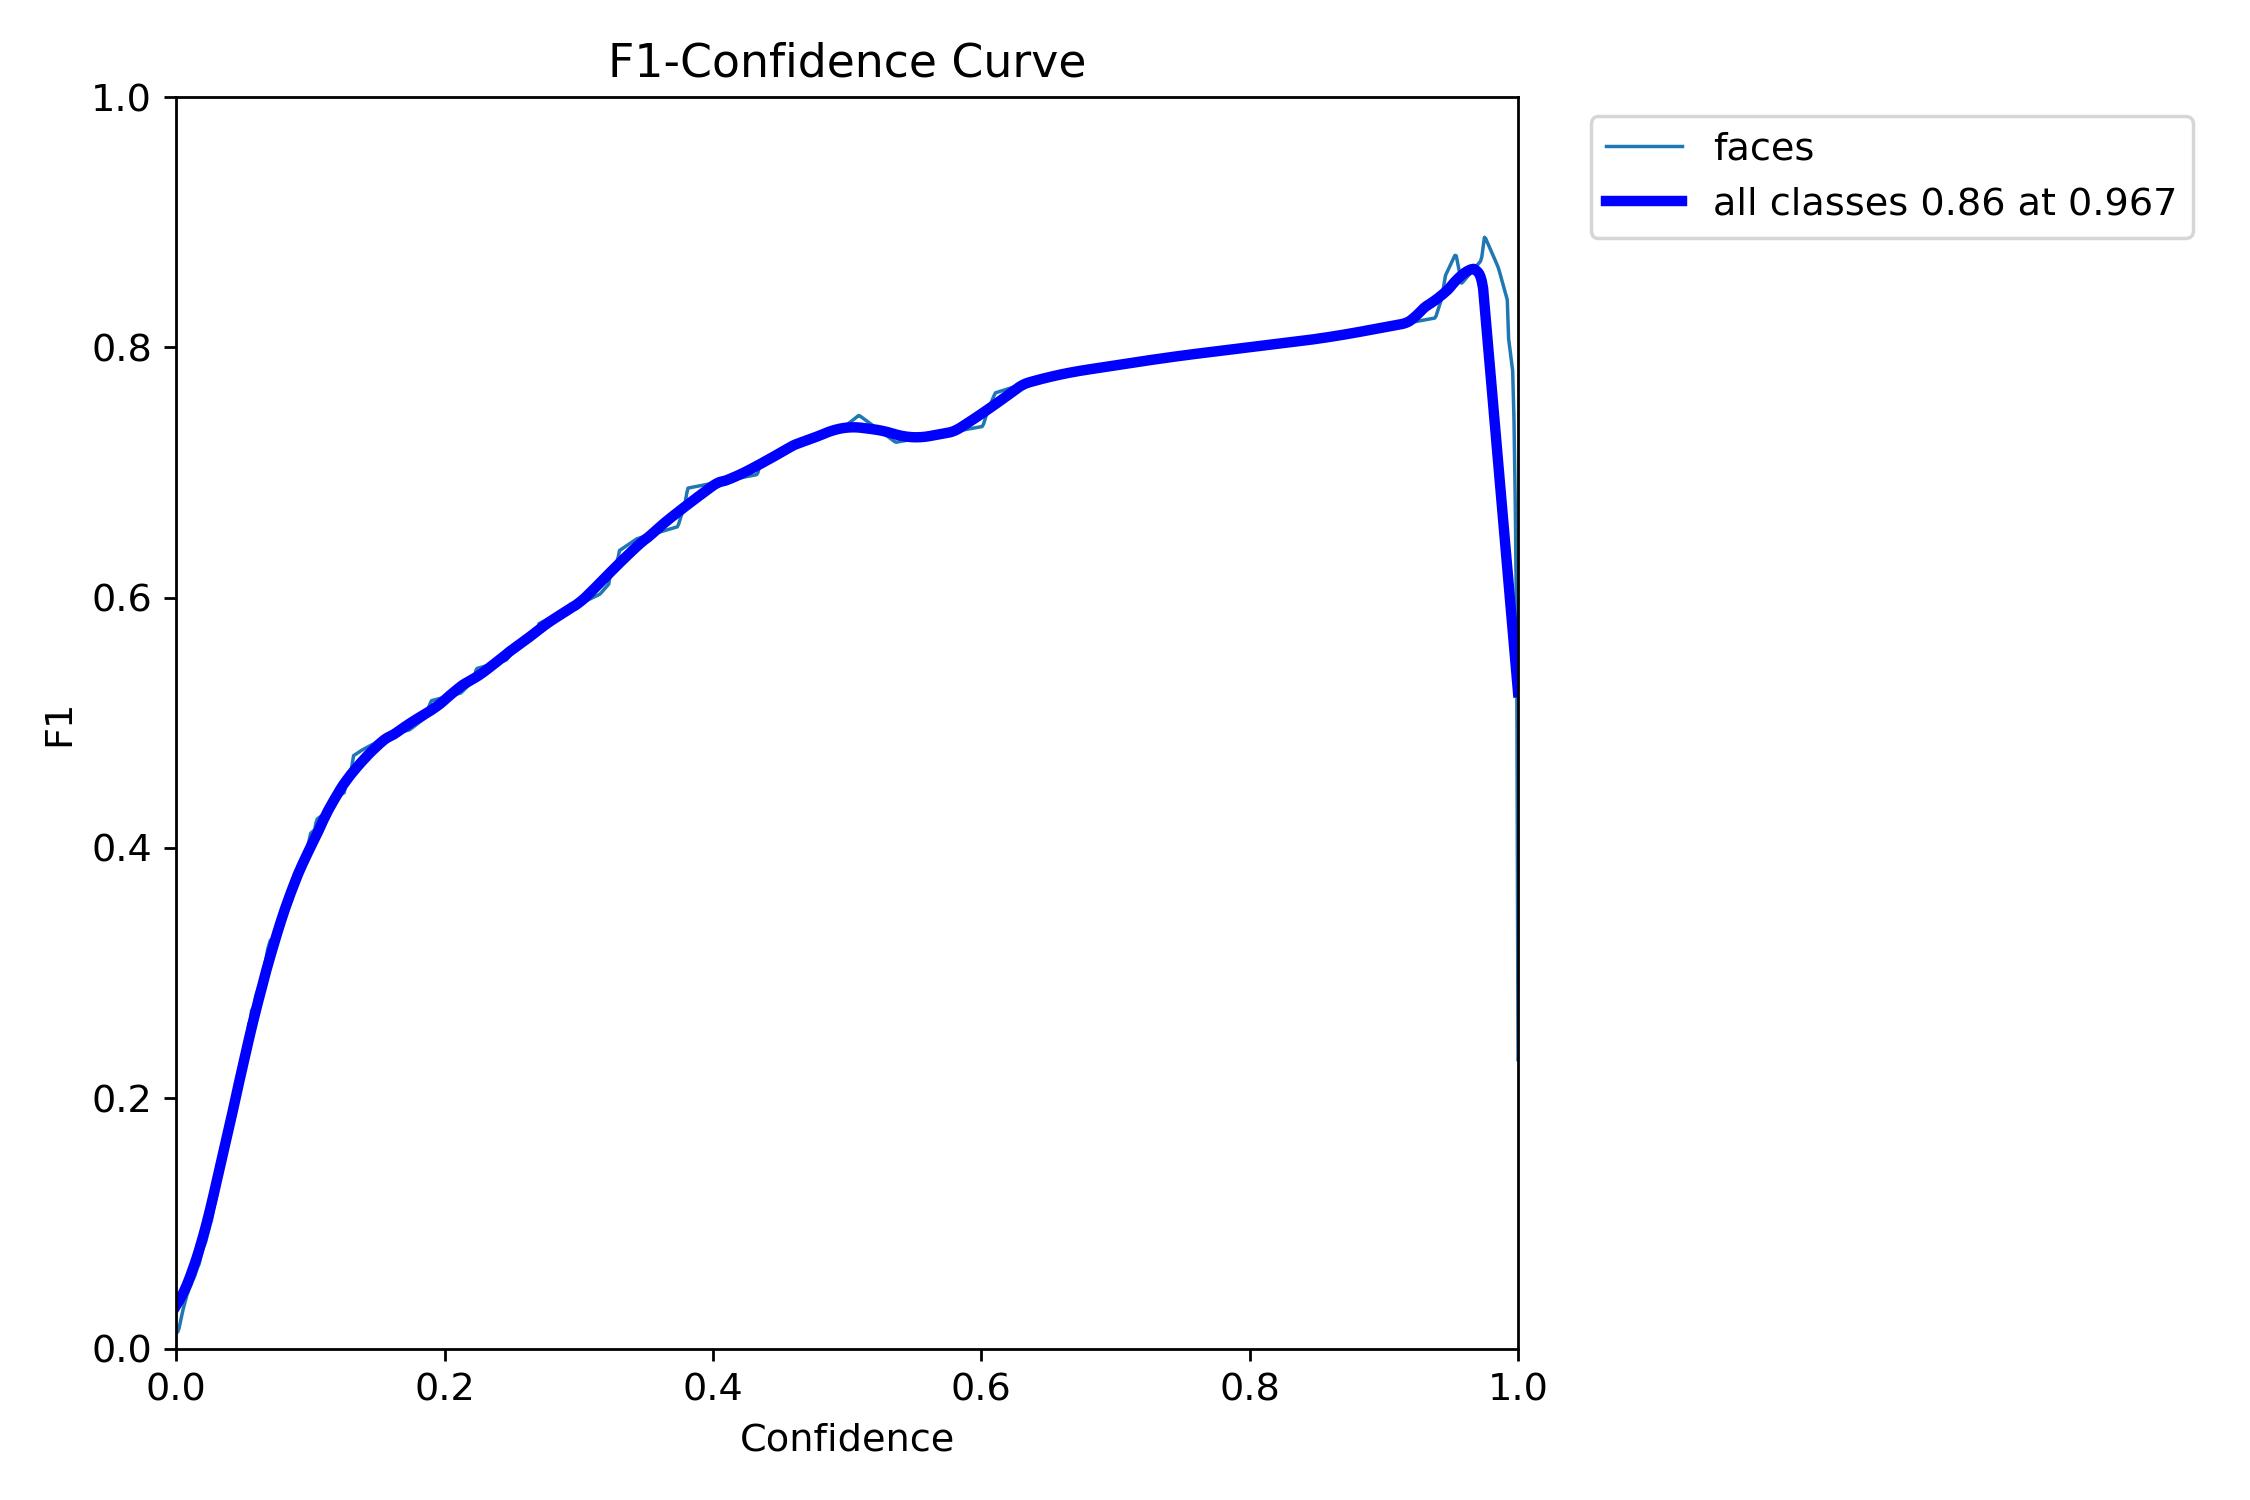

In [ ]:
Image.open("/content/runs/detect/train/F1_curve.png")

The F-measure is the weighted harmonic mean of precision and recall. It means that both metrics have the same importance. In our case, the confidence value that optimizes the precision and recall is 0.86, corresponding to the maximum F1 value (0.967). As a rule of thumb, higher confidence value and F1 score are desirable. So, our model performs well.

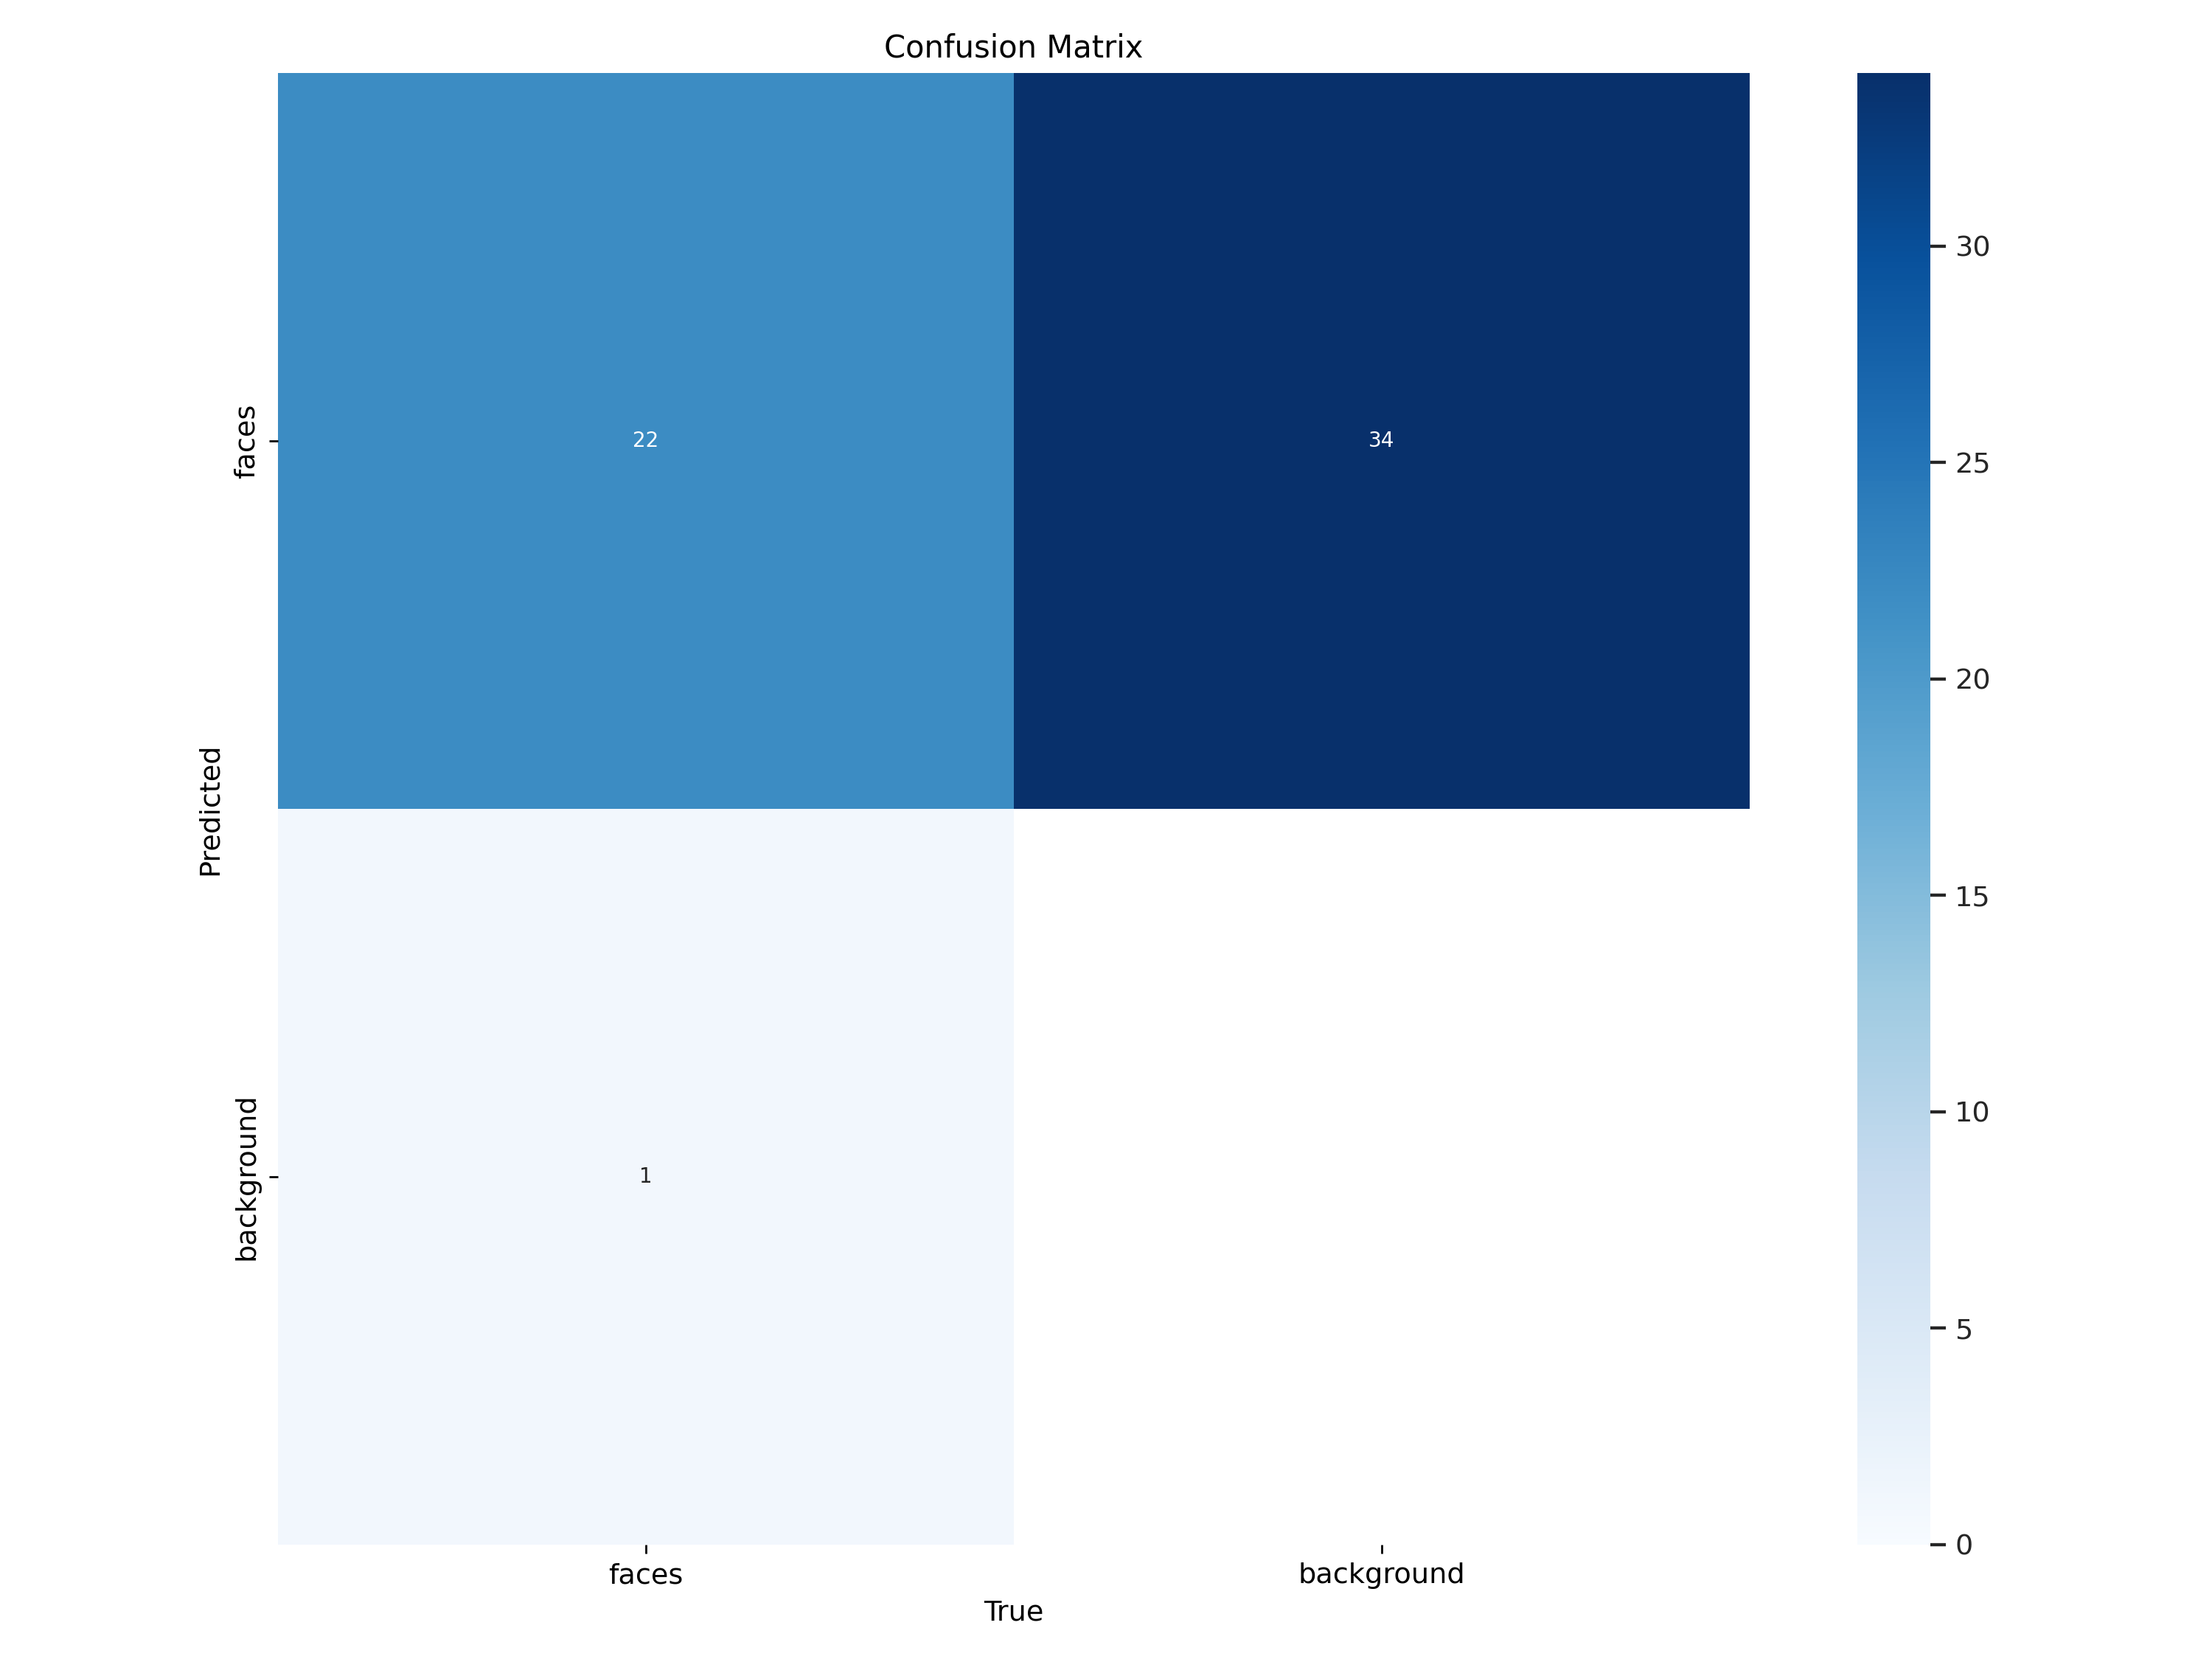

In [ ]:
Image.open("/content/runs/detect/train/confusion_matrix.png")



The confusion matrix shows that we correctly assign bounding boxes to 22 faces. Only 1 face had not been detected and the model confused the background with a face 34 times.

### Validation

For valdation of our detection task we take the best learned weights. The data location is given in the data_changed.yaml

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=../content/drive/MyDrive/ComputerVision/Code/data_changed_60_faces.yaml

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/Faces_512x512-1/valid/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100% 12/12 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.78it/s]
                   all         12         23      0.791      0.913      0.906       0.54
Speed: 0.2ms preprocess, 29.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


The model performs as follows:

Precision: 0.791

Recall: 0.913

MAP50: 0.906

###Prediction

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.3 source={dataset.location}/test/images save=True

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/6 /content/Faces_512x512-1/test/images/00000004_jpg.rf.d1a87dee11859c2db0ce1b73e1d5e9d8.jpg: 640x640 6 facess, 36.9ms
image 2/6 /content/Faces_512x512-1/test/images/00001497_jpg.rf.97cdccd7371683abe3181b45b173ef87.jpg: 640x640 6 facess, 37.0ms
image 3/6 /content/Faces_512x512-1/test/images/00002015_jpg.rf.889e4f11ccceb27b5a92b05b875c1147.jpg: 640x640 6 facess, 33.8ms
image 4/6 /content/Faces_512x512-1/test/images/00002571_jpg.rf.1f42409d19674504ee61bfd5f20df8b4.jpg: 640x640 3 facess, 30.9ms
image 5/6 /content/Faces_512x512-1/test/images/00002798_jpg.rf.9aaca982d51c3659b98a2ddab51a8b63.jpg: 640x640 8 facess, 30.9ms
image 6/6 /content/Faces_512x512-1/test/images/00003492_jpg.rf.41817580a47eb7875e7483757aa75782.jpg: 640x640 5 facess, 30.9ms
Speed: 1.6ms preprocess, 33.4ms inference, 1.4ms postprocess per image at 

### Create and save the best model

With the best weights learned we create the model with the YOLO architecture.

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')


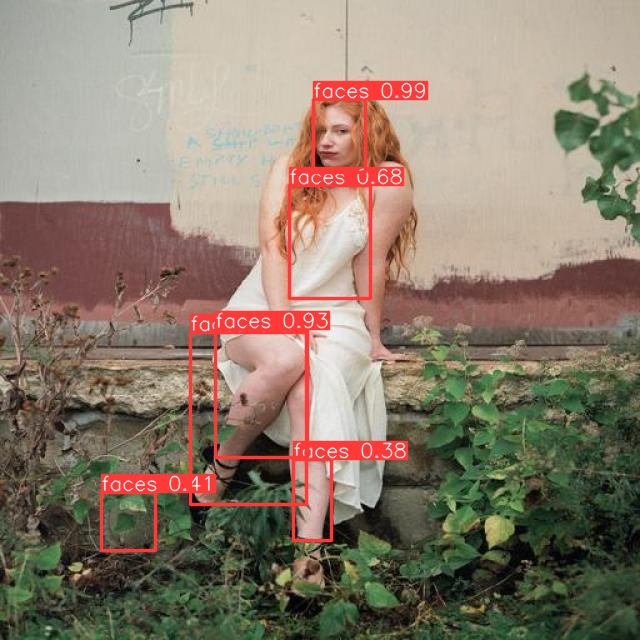

In [ ]:
image = Image.open("/content/runs/detect/predict/00000004_jpg.rf.d1a87dee11859c2db0ce1b73e1d5e9d8.jpg")
image = np.array(image)
image[:, :, [0, 2]] = image[:, :, [2, 0]]
cv2_imshow(image)

We save the model:

In [ ]:
torch.save(model,"../content/drive/MyDrive/ComputerVision/Models/object_detection_60_faces.pt")

###Inference

We want to detect faces in our picture. For this we load the picture and our pretrained model. The model predicts faces with the method predict and uses only one class.

In [ ]:
img="/content/drive/MyDrive/ComputerVision/Our Pictures/IMG_20230908_145659.jpg"


In [ ]:
model_1=torch.load("../content/drive/MyDrive/ComputerVision/Models/object_detection_60_faces.pt")

In [ ]:
results=model_1.predict(source=img,save=True,classes=0)



image 1/1 /content/drive/MyDrive/ComputerVision/Our Pictures/IMG_20230908_145659.jpg: 640x480 12 facess, 66.3ms
Speed: 3.5ms preprocess, 66.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict2


we print the original picture

In [ ]:
image = Image.open(img)
image = np.array(image)
image=cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
image[:, :, [0, 2]] = image[:, :, [2, 0]]
cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
clf=tf.keras.models.load_model("../content/drive/MyDrive/ComputerVision/Models/CNN.h5")

In [ ]:
### sentiment

for box,conf in zip(results[0].boxes.xywh,results[0].boxes.conf):
    x, y, width, height = box  # Unpack the coordinates

    # Convert float values to integers
    x, y, width, height = int(x), int(y), int(width), int(height)

    cv2.rectangle(image, (int(x - 0.5*width), int(y - 0.5*height)), (int(x + 0.5*width), int(y + 0.5*height)), (0, 255, 0), 4)

    x1 = int(x - width / 2)
    y1 = int(y - height / 2)
    x2 = int(x + width / 2)
    y2 = int(y + height / 2)


    cv2.putText(image, str(float(conf.cpu().numpy())), (int(x- 0.5*width), int(y- 0.5*height) ), cv2.FONT_HERSHEY_SIMPLEX,3, (0, 255, 0), 4)
cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.